**IMPORT LIBRARY**

In [2]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

**SET FUNCTION FOR ACCURACY CHART**

In [3]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

**LOAD AG NEWS SUBSET DATASET**

AG is a collection of more than 1 million news articles. Labelled into 4 types of category: 0-World/General, 1-Sports, 2-Business, 3-SciTech. Please refer to this link for more info: https://www.tensorflow.org/datasets/catalog/ag_news_subset

In [4]:
#RUN THIS TWICE! I don't really understand why, but the first one always failed. But the second one is always works.

dataset= tfds.load('ag_news_subset', as_supervised=True)

In [5]:
#Obtain dataset for training and testing

train_dataset, test_dataset = dataset['train'], dataset['test']
train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [6]:
#Show example of data and labelling
#0-World, 1-Sports, 2-Business, 3-Tech 
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b'AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.'
label:  3


**DATA PREPARATION**

In [7]:
#Set buffer size and batch size for optimization
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [8]:
#Autotune the dataset
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [9]:
#Check the autotune result, shuffled from before
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[3])
  print()
  print('labels: ', label.numpy()[3])

texts:  b'(Sports Network) - Winners in four of their last five games, the Detroit Tigers hand the ball to 23-year-old lefthander Wilfredo Ledezma tonight for the middle portion of a three-game series with the Chicago White Sox at Comerica Park.'

labels:  1


In [10]:
#Set Vocabulary size and vectorize the data
VOCAB_SIZE = 10000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

**CREATE MODEL**

In this model, I use one layer of LSTM. I was trying to use CuDNNLSTM, because the process is faster when using GPU (and it is 2 times faster than ordinary LSTM). However, the accuracy somehow worse than the ordinary LSTM. So I switched it back.

I use dropout because there is a tendency of the model to overfit. Especially when doing more than 10 epochs.

In [11]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    #tf.keras.layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4) #number of class: 0,1,2,3.
])

Sparse Categorical Crossentropy is used when there are more than one class and the information of the class is in 1 field (not hot-encoded). For more info: https://keras.io/api/losses/probabilistic_losses/#sparsecategoricalcrossentropy-class

In [12]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [13]:
history = model.fit(train_dataset, epochs=15,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/15
1875/1875 [==============================] - 56s 25ms/step - loss: 0.6741 - accuracy: 0.7428 - val_loss: 0.3706 - val_accuracy: 0.8807
Epoch 2/15
1875/1875 [==============================] - 46s 24ms/step - loss: 0.3452 - accuracy: 0.8905 - val_loss: 0.3202 - val_accuracy: 0.8964
Epoch 3/15
1875/1875 [==============================] - 46s 25ms/step - loss: 0.2935 - accuracy: 0.9069 - val_loss: 0.3117 - val_accuracy: 0.8969
Epoch 4/15
1875/1875 [==============================] - 46s 24ms/step - loss: 0.2621 - accuracy: 0.9174 - val_loss: 0.3035 - val_accuracy: 0.9073
Epoch 5/15
1875/1875 [==============================] - 46s 24ms/step - loss: 0.2399 - accuracy: 0.9240 - val_loss: 0.2862 - val_accuracy: 0.9078
Epoch 6/15
1875/1875 [==============================] - 46s 24ms/step - loss: 0.2216 - accuracy: 0.9294 - val_loss: 0.2926 - val_accuracy: 0.9078
Epoch 7/15
1875/1875 [==============================] - 46s 25ms/step - loss: 0.2076 - accuracy: 0.9338 - val_loss: 0.3080 -

In [14]:
#Model Accuracy

test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

119/119 [==============================] - 1s 11ms/step - loss: 0.4007 - accuracy: 0.8899
Test Loss: 0.4006781578063965
Test Accuracy: 0.889868438243866


(0.0, 0.7007512003183365)

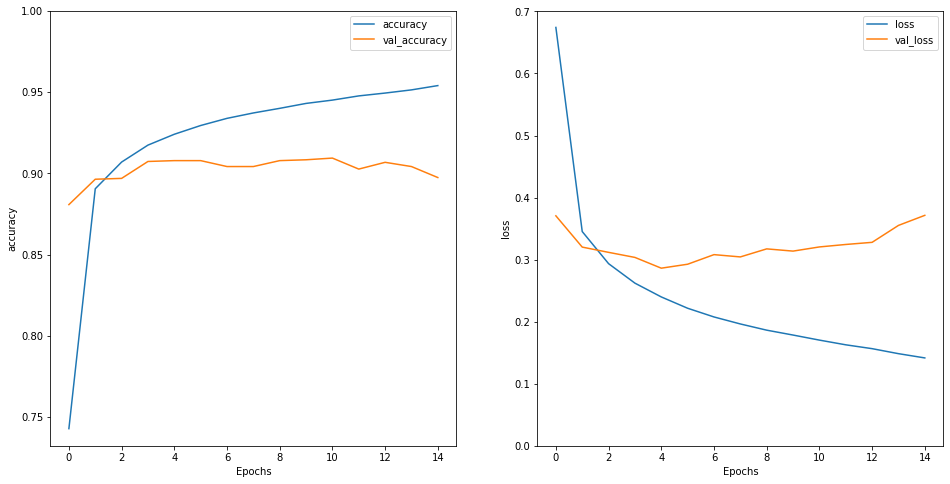

In [15]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

**TEST BY INPUT NEW TEXT**

In [16]:
#Create a list of labels

label_class=[]
label_class.append("World") #0
label_class.append("Sports") #1
label_class.append("Business") #2
label_class.append("SciTech") #3

The result of prediction will be an array of scores for each classes. In this code, I iterate the score for each class and return the highest score + the index. The index then will be passed to list of labels.

In [17]:
sample_text = ('KGB starts a new cold war with CIA in issue of brexit')
predictions = model.predict(np.array([sample_text]))
array_score = predictions[0]

i=0
max_score =-99
index = 0
for score in array_score:
  if score > max_score:
    max_score = score
    index = i
  else:
    max_score=max_score
    index=index
  i=i+1
print(sample_text)
print("This news is in category:")
print(label_class[index])



KGB starts a new cold war with CIA in issue of brexit
This news is in category:
World


In [18]:
#To check the prediction score for each class
array_score

array([ 2.7397304, -1.7716445, -1.5813339, -0.4825864], dtype=float32)

**OPTIONAL**

The model below is using one more LSTM layer. I've tried to use it, but the result is pretty much the same.

In [19]:
#ADD MORE LSTM LAYER
model2 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), output_dim=64, mask_zero=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4)
])

In [20]:
model2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [21]:
history = model2.fit(train_dataset, epochs=15,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/15
1875/1875 [==============================] - 51s 24ms/step - loss: 0.7135 - accuracy: 0.6788 - val_loss: 0.3687 - val_accuracy: 0.8818
Epoch 2/15
1875/1875 [==============================] - 45s 24ms/step - loss: 0.3484 - accuracy: 0.8936 - val_loss: 0.3071 - val_accuracy: 0.9016
Epoch 3/15
1875/1875 [==============================] - 45s 24ms/step - loss: 0.2847 - accuracy: 0.9153 - val_loss: 0.2981 - val_accuracy: 0.9068
Epoch 4/15
1875/1875 [==============================] - 45s 24ms/step - loss: 0.2529 - accuracy: 0.9248 - val_loss: 0.3136 - val_accuracy: 0.9057
Epoch 5/15
1875/1875 [==============================] - 46s 24ms/step - loss: 0.2300 - accuracy: 0.9313 - val_loss: 0.3049 - val_accuracy: 0.9078
Epoch 6/15
1875/1875 [==============================] - 45s 24ms/step - loss: 0.2136 - accuracy: 0.9363 - val_loss: 0.3220 - val_accuracy: 0.9052
Epoch 7/15
1875/1875 [==============================] - 44s 23ms/step - loss: 0.1984 - accuracy: 0.9418 - val_loss: 0.3292 -

In [22]:
#Model Accuracy

test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

119/119 [==============================] - 1s 8ms/step - loss: 0.4007 - accuracy: 0.8899
Test Loss: 0.4006781578063965
Test Accuracy: 0.889868438243866


(0.0, 0.7428905725479126)

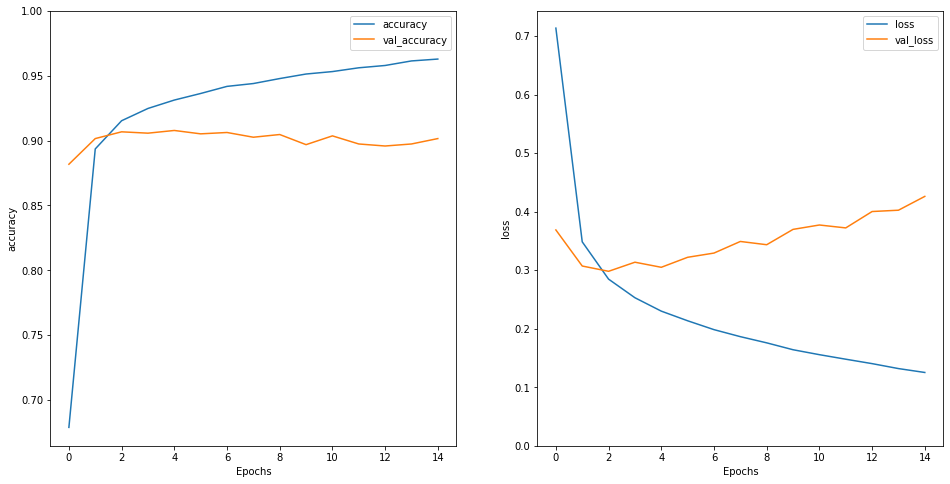

In [23]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [24]:
#Testing
sample_text = ('Manchester United signs another striker')
predictions = model2.predict(np.array([sample_text]))
array_score = predictions[0]

i=0
max_score =-99
index = 0
for score in array_score:
  if score > max_score:
    max_score = score
    index = i
  else:
    max_score=max_score
    index=index
  i=i+1
print(sample_text)
print("This news is in category:")
print(label_class[index])

Manchester United signs another striker
This news is in category:
Sports


In [25]:
#Check score for all class
array_score

array([-0.15432651,  1.7783105 , -1.834594  , -1.6152693 ], dtype=float32)